In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# change to the directory that contains the data
main_path = "/content/drive/MyDrive/UdacityND/project_caps/"

In [3]:
jigsaw_path = main_path+"train.csv"
val_data_path = main_path+"validation_data.csv"
comments_to_score_path = main_path+"comments_to_score.csv"
ruddit_path = main_path+"ruddit_with_text.csv"
new_data_path = main_path+"train_data_version2.csv"

In [4]:
# Imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import random
random.seed(123)
import sys
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import pickle
import joblib

import seaborn as sns
sns.set_theme(style="whitegrid")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [5]:
#Read in the data, ref: https://www.kaggle.com/andrej0marinchenko/best-score-0-856-jigsaw-for-beginners
def read_jigsaw_toxic_data(train_df_path,  fold_num, use_folds = False, approach = 1):
  '''
  Read in the toxic jigsaw data
  
  Inputs:
    train_df_path -> path of the file to read
    fold_num -> indicates the number of folds if they are usen
    use_folds -> whehter to use folds or not
  Output: 
    balanced_df -> a balanced df that has 3 coloumns, comment_text is the text of the comment, toxic_vs_not whether the comment is toxic or not,
  y the score of the toxicity calculated
  '''
  df = pd.read_csv(train_df_path)
  toxic_cols = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']
  # add a coloumn to indicate whether the comment is toxic or not
  # 0 and 1 approach
  df['toxic_vs_not'] = np.where(df[toxic_cols].sum(axis=1)==0, 0, 1) #0 if not toxic, 1 if toxic
  # another approach instead of 0 and 1
  if(approach==1):
    df['severe_toxic'] = df.severe_toxic * 2
    df['y'] = (df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1) ).astype(int)
    df['y'] = df['y']/df['y'].max()
  else:
    df['obscene'] = df.obscene * 0.16
    df['toxic'] = df.toxic * 0.32
    df['threat'] = df.threat * 1.5
    df['insult'] = df.insult * 0.64
    df['severe_toxic'] = df.severe_toxic * 1.5
    df['identity_hate'] = df.identity_hate * 1.5
    df['y'] = (df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1) ).astype(float)
    #df['y'] = df['y']/df['y'].max()
   
  
  fig, ax = plt.subplots()
  ax = sns.countplot(x="toxic_vs_not", data=df)
  count_toxic = df['toxic_vs_not'].value_counts()[1]
  print(count_toxic)
  if(use_folds==False):
    balanced_df = pd.concat([df[df.y>0].sample(frac=1, random_state = 10*(fold_num+1)),df[df.y==0].sample(int(count_toxic), random_state = 10*(fold_num+1))], axis=0)
  else:
    balanced_df = pd.concat([df[df.y>0].sample(frac=0.8, random_state = 10*(fold_num+1)),df[df.y==0].sample(int(0.8*count_toxic), random_state = 10*(fold_num+1))], axis=0)
  fig2, ax2 = plt.subplots()
  ax2 = sns.histplot(data=balanced_df,x='y',bins = 10, binwidth=0.08)
  
  return df
  

16225


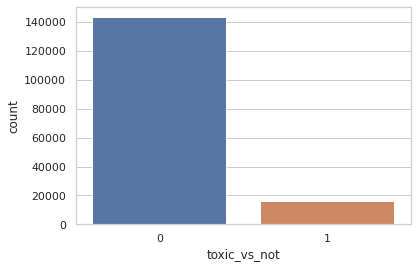

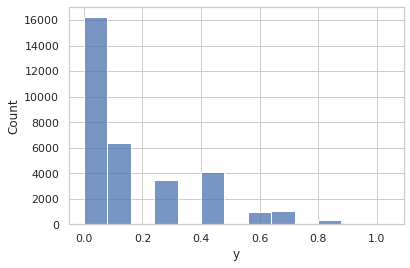

In [6]:
jigsaw_df = read_jigsaw_toxic_data(jigsaw_path,0 )

In [7]:
# ref: https://www.kaggle.com/andrej0marinchenko/best-score-0-856-jigsaw-for-beginners
def read_ruddit_toxic_data(ruddit_path, fold_num = 0, use_folds = False):
  '''
  Read in ruddit toxic data
  
  Inputs:
    ruddit_path  ->  path of the file to read
    fold_num -> indicates the number of folds if they are usen
    use_folds -> whehter to use folds or not
  
  Output: 
    df  -> a df that has 2 coloumns, comment_text is the text of the comment,
  y the score of the toxicity calculated
  '''
  df = pd.read_csv(ruddit_path)
  #print('Shape of Ruddit data is '+str(df.shape))
  df = df[['txt', 'offensiveness_score']].rename(columns={'txt': 'comment_text','offensiveness_score':'y'})
  fig, ax = plt.subplots()
  ax = sns.histplot(data=df,x='y',bins = 10, binwidth=0.08)
  df['y'] = (df['y'] - df.y.min()) / (df.y.max() - df.y.min()) 
  if(use_folds==True):
    df = df.sample(frac=0.8, random_state = 10*(fold_num+1))
  fig, ax = plt.subplots()
  ax = sns.histplot(data=df,x='y',bins = 10, binwidth=0.08)
  return df[['comment_text','y']]

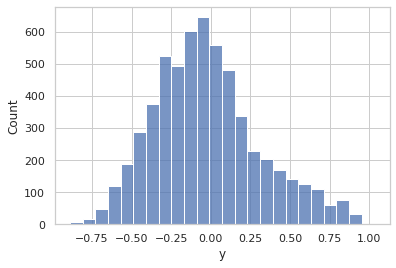

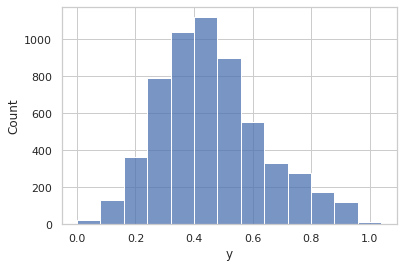

In [8]:
ruddit_df = read_ruddit_toxic_data(ruddit_path)

In [9]:
def read_new_toxic_data(new_path, fold_num = 0, use_folds = False):
  '''
  Read in alternative jigsaw data
  
  Inputs:
    new_path -> path of the file to read
    fold_num -> indicates the number of folds if they are usen
    use_folds -> whehter to use folds or not
  
  Output: 
    df  -> a balanced df that has 2 coloumns, comment_text is the text of the comment,
  y the score of the toxicity calculated
  '''
  df = pd.read_csv(new_path)
  df = df[['text','y']].rename(columns={'text': 'comment_text'})
  if(use_folds==True):
    df = df.sample(frac=0.8, random_state = 10*(fold_num+1))

  fig, ax = plt.subplots()
  ax = sns.histplot(data=df,x='y',bins = 10, binwidth=0.08)
  return df[['comment_text','y']]  

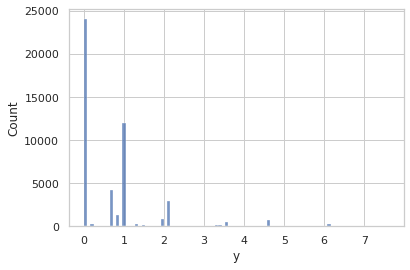

In [10]:
new_toxic_df = read_new_toxic_data(new_data_path)

In [11]:
def cleaner(text,use_lemmatizer=True):
    '''
    A function to clean the text
    
    Inputs:
        text -> The text that should be cleaned 
    
    Outputs:
        clean_tokens -> A list of tokens extracted from text after case normalizing, removing stop words and lemmatizing  
    '''
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, "urlplaceholder")
    words = word_tokenize(text)
    words = [word for word in words if word.isalpha()] #remove anything that is not alpha numeric
    lemmatizer = WordNetLemmatizer()
    clean_tokens = []
    for tok in words:
        if tok not in stopwords.words("english"):
            if(use_lemmatizer == True):
              clean_tok = lemmatizer.lemmatize(tok).lower().strip()
            else:
              clean_tok = tok.lower().strip()
            clean_tokens.append(clean_tok)
    return ' '.join(clean_tokens)

In [ ]:
# load and save clean jigsaw data
cleaned_jigsaw_text = jigsaw_df['comment_text'].apply(cleaner)
jigsaw_df['comment_text'] = cleaned_jigsaw_text
jigsaw_df.to_csv('jigsaw.csv',index=False)

In [ ]:
# load and save clean ruddit data
cleaned_ruddit_text = ruddit_df['comment_text'].apply(cleaner)
ruddit_df['comment_text'] = cleaned_ruddit_text
ruddit_df.to_csv('ruddit.csv',index=False)

In [ ]:
# load and save clean new data
cleaned_new_toxic_text = new_toxic_df['comment_text'].apply(cleaner)
new_toxic_df['comment_text'] = cleaned_new_toxic_text
new_toxic_df.to_csv('new_toxic.csv',index=False)

In [ ]:
# load, clean and save validation data
all_val_data = pd.read_csv(val_data_path)
less_toxic_data = all_val_data['less_toxic'].apply(cleaner)
more_toxic_data = all_val_data['more_toxic'].apply(cleaner)
all_val_data['less_toxic'] =  less_toxic_data
all_val_data['more_toxic'] = more_toxic_data
all_val_data.to_csv('val_data.csv',index=False)


In [ ]:
# load, clean and save new comments that are to be scored
new_comments = pd.read_csv(comments_to_score_path)
temp = new_comments['text'].apply(cleaner)
new_comments['comments'] = temp
new_comments.to_csv('comments_to_score.csv',index=False)